<a href="https://colab.research.google.com/github/epetrovic23/Utjecaj_atmosferskih_prilika_na_ishod_utrka_Formule1/blob/main/epetrovic23_Utjecaj_atmosferskih_prilika_na_ishod_utrka_Formule1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projekt: Analiza utjecaja vremenskih uvjeta na F1 utrke kroz integraciju povijesnih i telemetrijskih podataka**
**Kolegij:** Programiranje za analizu podataka
**Student:** Eva Petrović

#1. Uvod

Formula 1 je jedan od tehnološki najnaprednijih sportova na svijetu, gdje o pobjedi često odlučuju milisekunde. Osim inženjerskih performansi bolida i vještine vozača, jedan od ključnih vanjskih faktora koji utječe na ishod utrke su vremenski uvjeti. **Temperatura staze** (*track temperature*) izravno diktira **prianjanje guma** (*grip*) i njihovu degradaciju, dok **temperatura zraka** utječe na hlađenje motora i aerodinamičku efikasnost.

## 1.1 Motivacija i cilj

Motivacija za ovaj projekt je istražiti postoji li korelacija između temperature staze i konačnog plasmana vozača u sezoni 2023.

Cilj projekta je razviti automatizirani sustav koji integrira:
* **Statičke povijesne podatke (CSV):** Podaci o utrkama i rezultatima (preuzeti s [Kaggle repozitorija](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020)).
* **Dinamičke telemetrijske podatke (REST API):** Meteorološki podaci dohvaćeni putem OpenF1 API-ja.

Sustav pohranjuje ove podatke u strukturiranu bazu za daljnju analizu i ekspoziciju putem vlastitog REST API-ja, te vizualno prikazuje kako se performanse najboljih vozača mijenjaju u ovisnosti o ekstremnim uvjetima (hladne vs. vruće staze).

# 2. Opis implementacije

Sustav je implementiran u programskom jeziku **Python** unutar **Jupyter Notebook** okruženja. Arhitektura rješenja sastoji se od četiri glavne komponente koje prate **ETL** (*Extract, Transform, Load*) paradigmu.

## 2.1. Prikupljanje podataka (Data Collection)
Sustav koristi dva heterogena izvora podataka:

* **Statički podaci (CSV):** S platforme *Kaggle* preuzeti su skupovi podataka `races.csv` (kalendar utrka), `results.csv` (rezultati) i `drivers.csv` (informacije o vozačima). Ovi podaci daju kontekst (tko je vozio, gdje i kada).
* **Dinamički podaci (REST API):** Korišten je javni **OpenF1 API**. Implementirana funkcija `get_all_weather_2023()` iterira kroz sve održane utrke u sezoni 2023. i za svaku šalje HTTP GET zahtjev na `/weather` endpoint kako bi dohvatila prosječnu temperaturu staze i zraka.

## 2.2. Integracija i pretprocesiranje (Data Integration)
Glavna logika nalazi se u funkciji `load_and_analyze()`. Izazov integracije rješen je mapiranjem podataka na temelju **datuma održavanja utrke**.

* Podaci s API-ja dolaze u **JSON** formatu te se konvertiraju u **Pandas DataFrame** radi izračuna srednjih vrijednosti.
* Koristeći biblioteku `pandas`, vrši se spajanje (`merge`) tablice rezultata s tablicom vozača i novoprikupljenim vremenskim podacima.
* Podaci se čiste metodom `dropna()`, čime se iz analize uklanjaju utrke za koje API nije vratio valjane meteorološke podatke.

## 2.3. Pohrana podataka (Storage)
Obrađeni i integrirani skup podataka osigurava se perzistencijom u relacijsku bazu podataka.

* Korišten je ORM alat **SQLAlchemy** za kreiranje lokalne **SQLite** baze podataka (`f1_project.db`).
* Podaci se spremaju u tablicu `race_stats`, što omogućuje naknadno dohvaćanje bez ponovnog pozivanja sporog API-ja.

## 2.4. Sučelje i Vizualizacija

* **REST API:** Pomoću mikro-okvira **Flask**, kreiran je lokalni web server s rutom `/api/data` koji omogućuje vanjskim klijentima dohvat obrađenih statistika u JSON formatu.
* **Vizualizacija:** Za analizu je korištena biblioteka **Seaborn**. Generiran je *scatter plot* koji prikazuje odnos temperature staze (X-os) i konačne pozicije (Y-os) za šest najuspješnijih vozača sezone, omogućujući vizualnu detekciju trendova.

# 3. Prikaz rada aplikacije
Aplikacija se izvršava sekvencijalno kroz ćelije u bilježnici.

* **Dohvat:** Prilikom pokretanja, skripta ispisuje status dohvata za svaku utrku (npr. ` Bahrain International Circuit: 28.5°C`), što korisniku daje uvid u napredak procesa.
* **Tablični prikaz:** Na kraju procesa prikazuje se prvih 5 redaka integriranog `final_df` skupa podataka koji sadrži spojene informacije (ime vozača, bodovi, temperatura).
* **Grafički prikaz:** Generira se grafikon na kojem je vidljivo grupiranje rezultata. Na Y-osi su prikazane pozicije od 1 do 20, dok X-os prikazuje raspon temperatura od cca 20°C do 50°C.

U ovom segmentu koda vrši se inicijalizacija programskog okruženja. Korištenjem naredbe `pip` instaliraju se potrebni paketi koji nisu predinstalirani u **Google Colabu**. Zatim se uvoze moduli potrebni za implementaciju **ETL** procesa (`pandas`, `requests`), perzistenciju podataka (`sqlalchemy`, `sqlite3`), izradu web servisa (`flask`, `threading`) i grafičku analizu (`matplotlib`, `seaborn`). Na kraju se definiraju globalne postavke za `pandas` kako bi se omogućio prikaz svih stupaca u `DataFrame`-u i suzbila upozorenja o budućim promjenama u biblioteci.

In [1]:
!pip install sqlalchemy flask pandas requests matplotlib seaborn

import pandas as pd
import requests
import sqlite3
from sqlalchemy import create_engine
import json
import threading
import time
from flask import Flask, jsonify, request
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)

print("Biblioteke uspješno učitane.")

Biblioteke uspješno učitane.


Ovaj programski odsječak predstavlja središnju logiku za **prikupljanje i integraciju podataka** (**ETL proces**). Definirane su dvije ključne funkcije: `get_all_weather_2023`, koja iterativno dohvaća telemetrijske podatke o vremenu s **OpenF1 API-ja** za svaku utrku sezone 2023., te `load_and_analyze`, koja učitava statičke CSV datoteke (`races`, `results`, `drivers`). Kod povezuje ova dva heterogena izvora mapiranjem prema **datumu utrke**, izračunava prosječne temperature staze i zraka, te konačno spaja sve informacije u jedinstveni `DataFrame` (`final_df`) koji sadrži imena vozača, njihove rezultate i pripadajuće vremenske uvjete.

In [2]:
import pandas as pd
import requests
import time
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)


def get_all_weather_2023():
    """Dohvaća temperature za SVE utrke u 2023."""
    print("Dohvaćam popis svih utrka 2023. s OpenF1 API-ja...")
    try:
        sessions = requests.get("https://api.openf1.org/v1/sessions?year=2023&session_name=Race").json()
    except Exception as e:
        return {}

    weather_map = {}
    print(f"Pronađeno {len(sessions)} utrka. Krećem u dohvat vremena (cca 30 sekundi)...")

    for session in sessions:
        date_str = session['date_start'][:10]
        try:
            url = f"https://api.openf1.org/v1/weather?meeting_key={session['meeting_key']}&session_key={session['session_key']}"
            w_resp = requests.get(url).json()
            if w_resp:
                w_df = pd.DataFrame(w_resp)
                weather_map[date_str] = (w_df['track_temperature'].mean(), w_df['air_temperature'].mean())
                print(f" {session['location_option']}: {weather_map[date_str][0]:.1f}°C")
        except:
            pass
        time.sleep(0.2)
    return weather_map

def load_and_analyze():
    print("--- 1. Učitavanje CSV-ova ---")
    try:
        races = pd.read_csv('races.csv')
        results = pd.read_csv('results.csv')
        drivers = pd.read_csv('drivers.csv')
    except FileNotFoundError:
        print("GREŠKA: Nedostaju CSV datoteke (races, results ili drivers).")
        return None

    races_2023 = races[races['year'] == 2023].copy()
    real_weather = get_all_weather_2023()

    def match_weather(row):
        return real_weather.get(row['date'], (None, None))

    races_2023[['track_temp', 'air_temp']] = races_2023.apply(lambda x: pd.Series(match_weather(x)), axis=1)

    races_clean = races_2023.dropna(subset=['track_temp'])
    merged = pd.merge(results, races_clean, on='raceId', how='inner')
    final = pd.merge(merged, drivers, on='driverId', how='left')

    final['Driver'] = final['forename'] + " " + final['surname']

    return final[['raceId', 'year', 'name', 'date', 'Driver', 'positionOrder', 'points', 'track_temp', 'air_temp']]

final_df = load_and_analyze()

if final_df is not None:
    print("\nGotovo! Prvih 5 redova:")
    display(final_df.head())

--- 1. Učitavanje CSV-ova ---
Dohvaćam popis svih utrka 2023. s OpenF1 API-ja...
Pronađeno 23 utrka. Krećem u dohvat vremena (cca 30 sekundi)...

Gotovo! Prvih 5 redova:


,raceId,year,name,date,Driver,positionOrder,points,track_temp,air_temp
0,1098,2023,Bahrain Grand Prix,2023-03-05,Max Verstappen,1,25.0,31.011801,27.431677
1,1098,2023,Bahrain Grand Prix,2023-03-05,Sergio Pérez,2,18.0,31.011801,27.431677
2,1098,2023,Bahrain Grand Prix,2023-03-05,Fernando Alonso,3,15.0,31.011801,27.431677
3,1098,2023,Bahrain Grand Prix,2023-03-05,Carlos Sainz,4,12.0,31.011801,27.431677
4,1098,2023,Bahrain Grand Prix,2023-03-05,Lewis Hamilton,5,10.0,31.011801,27.431677


Ovaj segment koda implementira sloj za **perzistenciju podataka**. Korištenjem ORM alata `SQLAlchemy` inicijalizira se veza (`engine`) prema lokalnoj **SQLite** bazi podataka naziva `f1_project.db`. Unutar sigurnosnog `try-except` bloka, sustav prvo validira postojanje obrađenog `DataFrame`-a `final_df`. Ukoliko su podaci dostupni, metoda `.to_sql()` vrši njihovu serijalizaciju i zapis u tablicu `race_stats`, pri čemu parametar `if_exists='replace'` osigurava da se pri svakom pokretanju tablica ažurira najnovijim podacima. Proces završava verifikacijskim korakom, gdje se putem izravnog SQL upita (`SELECT count(*)`) provjerava integritet zapisa i ispisuje ukupan broj redaka pohranjenih u bazu.

In [3]:
from sqlalchemy import create_engine, text

db_name = 'f1_project.db'
engine = create_engine(f'sqlite:///{db_name}')

try:
    if 'final_df' in locals() and final_df is not None:

        final_df.to_sql('race_stats', con=engine, if_exists='replace', index=False)
        print(f"Podaci uspješno spremljeni u bazu '{db_name}', tablica 'race_stats'.")

        with engine.connect() as conn:
            result = conn.execute(text("SELECT count(*) FROM race_stats")).scalar()
            print(f" Broj zapisa u bazi: {result}")

    else:
        print(" Varijabla 'final_df' je prazna ili nije pronađena.")
        print("Prvo pokreni ćeliju iznad (onu veliku s funkcijom load_and_analyze)!")

except NameError:
    print("GREŠKA: Varijabla 'final_df' uopće ne postoji.")
    print("RJEŠENJE: Vrati se na ćeliju iznad i stisni 'Play' da se podaci učitaju.")

Podaci uspješno spremljeni u bazu 'f1_project.db', tablica 'race_stats'.
 Broj zapisa u bazi: 440


Prikazani blok koda demonstrira implementaciju **REST API sučelja** koristeći mikro-okvir **Flask**. Naredba `%%writefile app.py` pohranjuje sadržaj ćelije u datoteku, čime se stvara modularna **Python** aplikacija. Sustav uspostavlja vezu s prethodno kreiranom **SQLite** bazom podataka i definira krajnju točku (*endpoint*) `/api/data`. Ova ruta obrađuje **HTTP GET** zahtjeve, omogućuje filtriranje podataka putem URL parametara (npr. filtriranje pobjednika) te koristi `pandas` za dohvat zapisa iz baze i njihovu konverziju u **JSON format**, koji je standard za razmjenu podataka na webu.

In [4]:
%%writefile app.py
from flask import Flask, jsonify, request
from sqlalchemy import create_engine
import pandas as pd

app = Flask(__name__)

engine = create_engine('sqlite:///f1_project.db')

@app.route('/', methods=['GET'])
def index():
    return "F1 Data API is running. Use /api/data to get stats."

@app.route('/api/data', methods=['GET'])
def get_data():
    """
    Dohvaća podatke iz baze i vraća ih kao JSON.
    Opcija filtriranja po poziciji (?pos=1 za pobjednike).
    """
    try:
        pos_filter = request.args.get('pos')

        query = "SELECT * FROM race_stats"

        if pos_filter:
            query += f" WHERE positionOrder = {pos_filter}"

        query += " LIMIT 50"

        df = pd.read_sql(query, engine)

        return jsonify(df.to_dict(orient='records'))

    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run(port=5000, debug=True)

Writing app.py


Prikazani segment koda služi za **pokretanje i integracijsko testiranje** **REST API servisa** unutar **Jupyter okruženja**. Proces započinje oslobađanjem mrežnog porta **5000** (naredba `fuser`) kako bi se izbjegli konflikti s prethodnim instancama. Zatim se, koristeći modul `subprocess`, **Flask aplikacija** (`app.py`) pokreće kao **pozadinski proces**, što omogućuje nesmetano izvršavanje daljnjih naredbi u bilježnici. Nakon kratke stabilizacijske pauze, skripta preuzima ulogu klijenta: pomoću biblioteke `requests` šalje **HTTP GET** zahtjev na lokalnu adresu (`localhost`), filtrira podatke za pobjednike utrka (`pos=1`) te ispisuje dobiveni **JSON odgovor** kao potvrdu ispravnog rada sustava.

In [5]:
import subprocess

!fuser -k 5000/tcp

process = subprocess.Popen(["python", "app.py"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

print("Server se pokreće u pozadini...")
time.sleep(3)

try:
    print("Šaljem testni upit na API...")
    response = requests.get("http://127.0.0.1:5000/api/data?pos=1")

    if response.status_code == 200:
        data = response.json()
        print("API Odgovor (Prva 3 zapisa):")
        print(json.dumps(data[:3], indent=2))
    else:
        print("API nije vratio 200 OK.")
except Exception as e:
    print(f"Nije moguće spojiti se na API: {e}")

Server se pokreće u pozadini...
Šaljem testni upit na API...
API Odgovor (Prva 3 zapisa):
[
  {
    "Driver": "Max Verstappen",
    "air_temp": 27.43167701863354,
    "date": "2023-03-05",
    "name": "Bahrain Grand Prix",
    "points": 25.0,
    "positionOrder": 1,
    "raceId": 1098,
    "track_temp": 31.01180124223602,
    "year": 2023
  },
  {
    "Driver": "Sergio P\u00e9rez",
    "air_temp": 26.09189189189189,
    "date": "2023-03-19",
    "name": "Saudi Arabian Grand Prix",
    "points": 25.0,
    "positionOrder": 1,
    "raceId": 1099,
    "track_temp": 31.79256756756757,
    "year": 2023
  },
  {
    "Driver": "Max Verstappen",
    "air_temp": 17.449549549549552,
    "date": "2023-04-02",
    "name": "Australian Grand Prix",
    "points": 25.0,
    "positionOrder": 1,
    "raceId": 1100,
    "track_temp": 30.13963963963964,
    "year": 2023
  }
]


Ovaj segment koda zadužen je za **grafičku vizualizaciju rezultata** analize. Kako bi se osigurala čitljivost grafikona, podaci se prvo filtriraju tako da se izdvoji samo šest najuspješnijih vozača prema ukupnom broju bodova u sezoni. Zatim se, koristeći biblioteku `seaborn`, generira **dijagram raspršenosti** (*scatter plot*) koji prikazuje korelaciju između temperature staze (X-os) i konačnog plasmana (Y-os). Ključni element vizualizacije je prilagodba Y-osi: ona je invertirana (`plt.ylim`) i fiksirana na cjelobrojne vrijednosti od 1 do 20, čime se intuitivno prikazuje da je **1. mjesto** na vrhu grafa, dok boje i simboli jasno diferenciraju pojedine vozače.

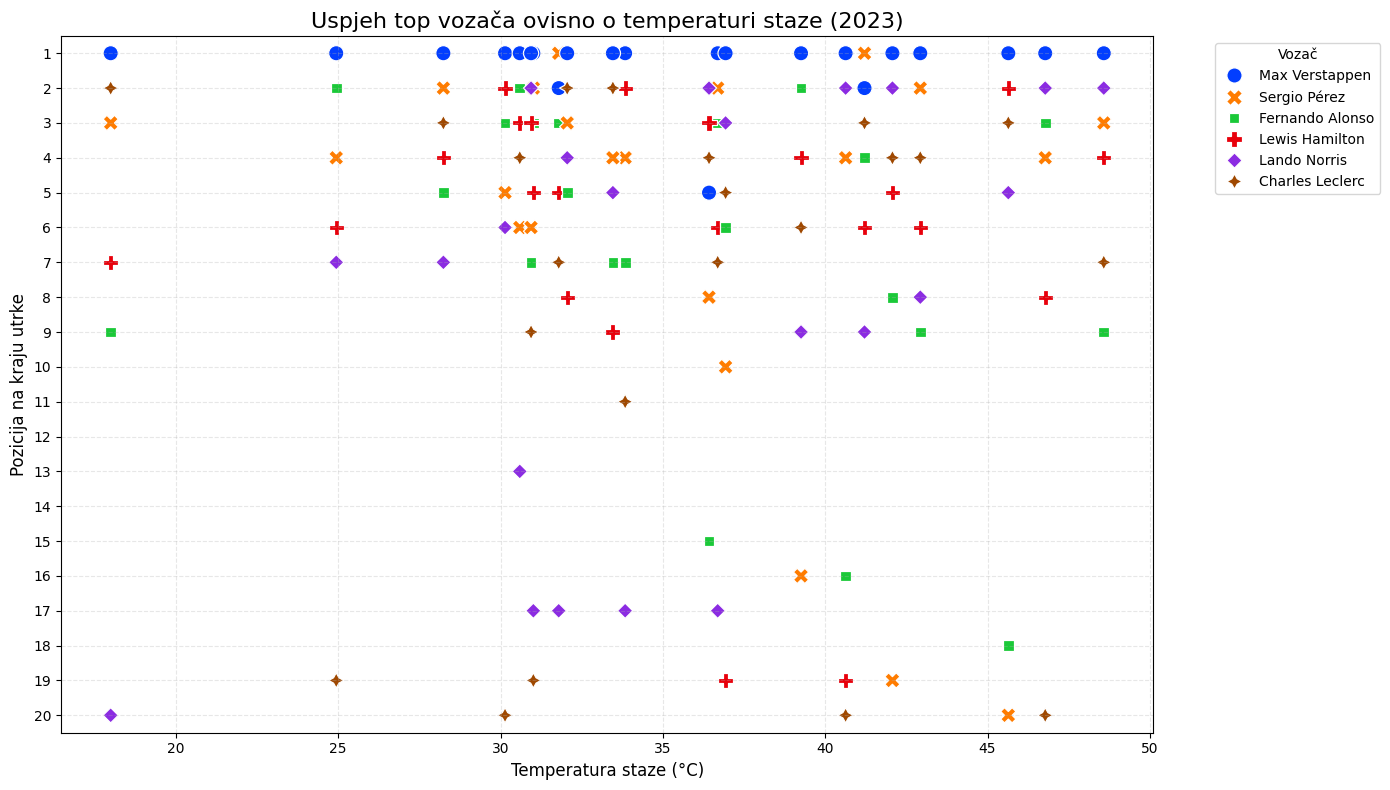

In [6]:
import numpy as np

if final_df is not None:
    plt.figure(figsize=(14, 8))

    top_drivers = final_df.groupby('Driver')['points'].sum().sort_values(ascending=False).head(6).index
    df_plot = final_df[final_df['Driver'].isin(top_drivers)]

    sns.scatterplot(
        data=df_plot,
        x='track_temp',
        y='positionOrder',
        hue='Driver',
        style='Driver',
        s=120,
        palette='bright'
    )

    plt.yticks(range(1, 21))
    plt.ylim(20.5, 0.5)

    plt.title('Uspjeh top vozača ovisno o temperaturi staze (2023)', fontsize=16)
    plt.xlabel('Temperatura staze (°C)', fontsize=12)
    plt.ylabel('Pozicija na kraju utrke', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Vozač")
    plt.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

# 4. Kritički osvrt
Praktična izvedba projekta pokazala je uspješnost u integraciji različitih formata podataka, no postoje određena ograničenja:

* **Performanse:** Dohvat podataka s API-ja je sinkron (utrka po utrka), što traje oko 30-40 sekundi za cijelu sezonu. U produkcijskom okruženju, ovo bi se trebalo optimizirati asinkronim pozivima (`asyncio`) ili lokalnim cacheiranjem podataka kako se API ne bi zvao pri svakom pokretanju.
* **Dostupnost podataka:** **OpenF1 API** nudi detaljne podatke tek za novije sezone (2023. nadalje), što onemogućuje povijesnu analizu kroz desetljeća koristeći isti izvor.
* **Primjena:** Ovakav sustav mogao bi poslužiti kao osnova za prediktivne modele u sportskom klađenju ili za timove koji žele analizirati performanse konkurencije u specifičnim uvjetima, pod uvjetom da se proširi s podacima o vrsti guma.

# 5. Zaključak
Ovaj projekt uspješno je demonstrirao cjelokupni ciklus inženjerske analize podataka: od prikupljanja sirovih podataka iz heterogenih izvora, preko njihovog čišćenja i pohrane, do izlaganja putem API-ja i vizualizacije.

Analizom sezone 2023. uočljivo je da dominantni vozač (**Max Verstappen**) ostvaruje pobjede neovisno o temperaturnim uvjetima, što ukazuje na superiornost bolida **Red Bull Racinga** u svim uvjetima. Kod ostalih vozača (npr. **Ferrari** i **Mercedes**) vidljive su varijacije u performansama, gdje određeni bolidi bolje funkcioniraju na nižim temperaturama staze, dok na visokim temperaturama gube performanse zbog pregrijavanja guma. Projekt potvrđuje da su Python alati (`pandas`, `sqlalchemy`, `flask`) izuzetno efikasni za brzu izradu prototipova analitičkih sustava.

# 6. Literatura
1. R. Rao, "Formula 1 World Championship (1950-2024)," Kaggle. [Online]. Dostupno: [https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020). [Pristupljeno: 22. prosinca 2025.].
2. OpenF1, "OpenF1 API Documentation," OpenF1. [Online]. Dostupno: [https://openf1.org](https://openf1.org). [Pristupljeno: 22. prosinca 2025.].
3. Pallets, "Flask Documentation (3.0.x)," Flask. [Online]. Dostupno: [https://flask.palletsprojects.com/](https://flask.palletsprojects.com/). [Pristupljeno: 22. prosinca 2025.].
4. Google, "Gemini (Generativna AI): Pomoć kod strukturiranja dokumenta i provjera ispravnosti rješenja," Google. [Online]. Dostupno: [https://gemini.google.com/share/88ce8cb81304](https://gemini.google.com/share/88ce8cb81304). [Pristupljeno: 22. siječnja 2026.].